# Analysis of the Boolean model of cell cycle by Sizek et al.

In this jupyter notebook, we will analyse different aspects of the cell cycle model published here : 
https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006402

In [40]:
import maboss
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import os
from tools import load_trajs, draw_graph_from_pandas, compute_circuits, compute_stg_counts

The model files are available in the config/cell_cycle/boolean_network folder of the tutorial sample project

In [48]:
path = "../config/cell_cycle/boolean_network/"
bnd_file = os.path.join(path, "intracellular_model.bnd")
cfg_file = os.path.join(path, "intracellular_model.cfg")

## Simulation of the wild type model

We initially load this model, and simulate it for 48 hours, focusing on Cyclin A, Cyclin B, Cyclin E and Caspase 3

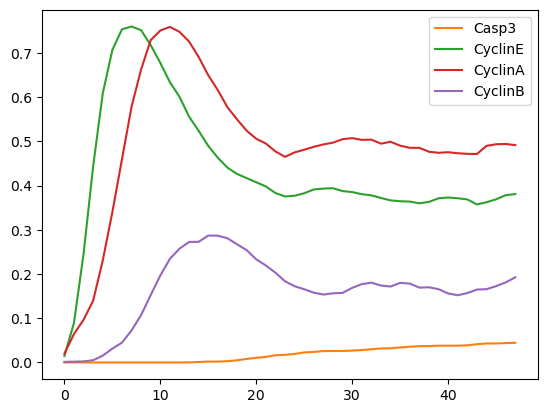

In [70]:
sim = maboss.load(bnd_file, cfg_file)
sim.update_parameters(max_time=48)
sim.network.set_output(["CyclinA", "CyclinB", "CyclinE", "Casp3"])

model = sim.run()
model.plot_node_trajectory()

We can observe here the classic sequence of cyclins activation : Cyclin E, followed by Cyclin A, and finally Cyclin B. 
But what we also observe, is that we very quickly loose this cyclic behavior : MaBoSS computes probability distribution. Since cells are not synchronized, very quickly what we obtain is just the average probability of each cyclin at any time point during the cell cycle. This informs us about the duration of the phases, but not about the sequential oscillations.

Aside the cyclin trajectory, we also observe the behavior of Caspase 3, which slowly increase during the simulation to reach about 5% after 48h. This means an average cell will have 5% chances of dying in 48 hours. We can simulate a longer time frame to see it's behavior on more than 48 hours.

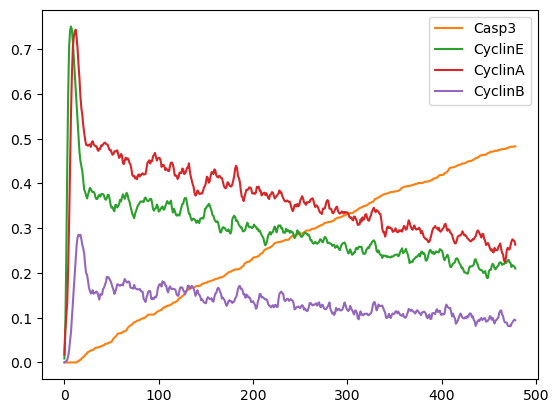

In [71]:
sim_long = sim.copy()
sim_long.update_parameters(max_time=480)
res_long = sim_long.run()
res_long.plot_node_trajectory()

Here we get a beter idea about the long term trajectory of the activation of Caspase 3 : after 480h (20 days), a cell has 50% chances of dying.

One way to try to see better the cyclins oscilations is to remove one of the two sources of stochasticity of MaBoSS : the transition time, by switching to discrete time simulation : 

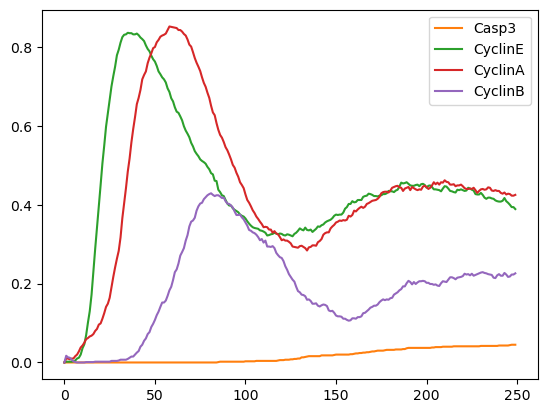

In [69]:
sim_discrete = sim.copy()
sim_discrete.update_parameters(discrete_time=1, max_time=250)
res_discrete = sim_discrete.run()
res_discrete.plot_node_trajectory()

We can indeed see a bit of a second oscillation, but barely. We still have one large source of stochasticity that we can't get rid of : the choice of the next transition, from the asynchronous update that MaBoSS is using. 

## Analysis of the model for PhysiBoSS with phenotypes output

Conditions describing the transition to a next phase of the cell cycle are not so obvious : It does not depend on only one cyclin, and we need to prevent some abherent phenotypes. 
To solve this, we added three new nodes : 
- G0G1 entry : representing the transition from G2M to G0G1
- S_entry : representing the transition from G0G1 to S phase
- G2M_entry : representing the transition from S to G2M

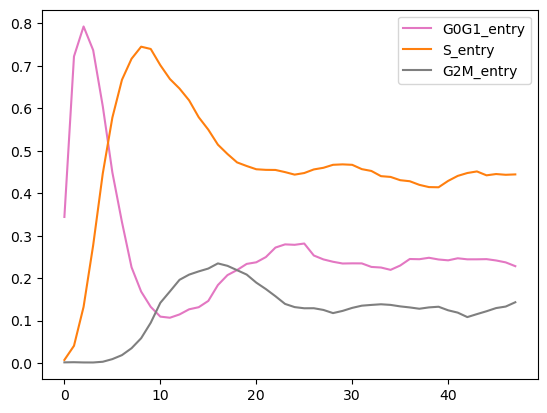

In [74]:
sim_phenotypes = sim.copy()
sim_phenotypes.network.set_output(['G0G1_entry', 'S_entry', 'G2M_entry'])
res_phenotypes = sim_phenotypes.run()
res_phenotypes.plot_node_trajectory()

We can observe in this simulation the sequence of transition which is expected : Cells first enter G0G1, then go to S, and finally to G2M. And then a new cycle starts

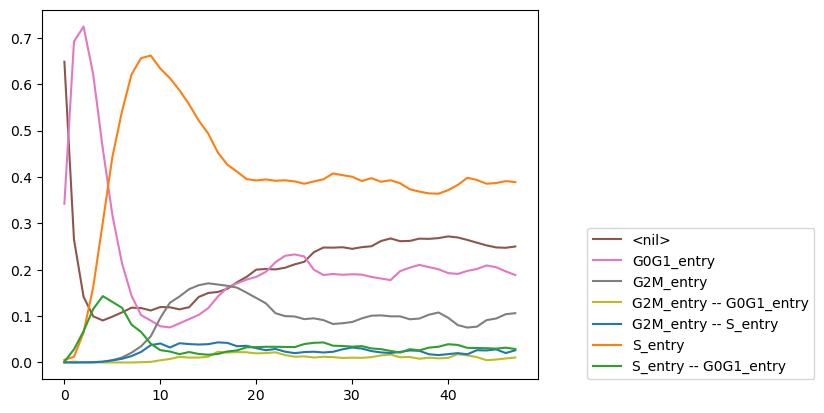

In [75]:
res_phenotypes.plot_trajectory()

Looking at the state trajectories, we can see a even more important detail : We start from a phase were no transition is active (\<nil\>), then activate the G0G1_entry. Then we activate S_entry, and subsequently inactivate G0G1_entry. We then activate G2M_entry, and again immediately inactivate S_entry. 
This is important because it gives us a clear information of the state of the system at any time. If for example we inactivated G0G1_entry before activating S_entry, we would end up up a \<nil\> state, without remembering in which phase we were. 

## Studying the sequence of transitions, and the possible cell cycles

One way to study the sequence of cell cycle phases would be to only focus on the transitions affecting these nodes, and completely ignore the other transitions. To do this, we need to look at the complete list of transitions, and filter out the transitions that don't interest us. 
First, we need to create a simulation with the display_traj setting active, and also reduce the number of cores used in the simulation to 1, as the display_traj mode only support single-core simulation. We also increase the simulation time, in order to get more transitions to get better statistics

In [83]:
sim_phenotypes_trajs = sim_phenotypes.copy()
sim_phenotypes_trajs.update_parameters(display_traj=1, thread_count=1, max_time=480)
res_phenotypes_trajs = sim_phenotypes_trajs.run()

Once the simulation has completed, we need to filter the trajectories by the cell cycle transition nodes, and build a simplified state transition matrix where we only have the states composed of these cell cycle transition nodes. 

In [85]:
outputs_phenotype = ["G0G1_entry", "G2M_entry", "S_entry"]
trajs, all_states = load_trajs(res_phenotypes_trajs._path, outputs_phenotype)
stg_counts, state_ids, ids_state = compute_stg_counts(trajs, all_states)
data = pd.DataFrame(
    data=stg_counts,
    index=state_ids.keys(), columns=state_ids.keys()
)
data

,<nil>,G0G1_entry,G0G1_entry -- G2M_entry,G0G1_entry -- S_entry,G2M_entry,G2M_entry -- S_entry,S_entry
<nil>,0.0,11052.0,0.0,0.0,0.0,0.0,3.0
G0G1_entry,2969.0,0.0,0.0,12658.0,0.0,0.0,0.0
G0G1_entry -- G2M_entry,0.0,4525.0,0.0,0.0,156.0,0.0,0.0
G0G1_entry -- S_entry,0.0,143.0,0.0,0.0,0.0,0.0,12497.0
G2M_entry,4509.0,0.0,4689.0,0.0,0.0,0.0,0.0
G2M_entry -- S_entry,0.0,0.0,0.0,0.0,9100.0,0.0,322.0
S_entry,3174.0,0.0,0.0,0.0,0.0,9432.0,0.0


We can then plot this matrix as a graph, and visualize the possible transition between all this subset of states. 

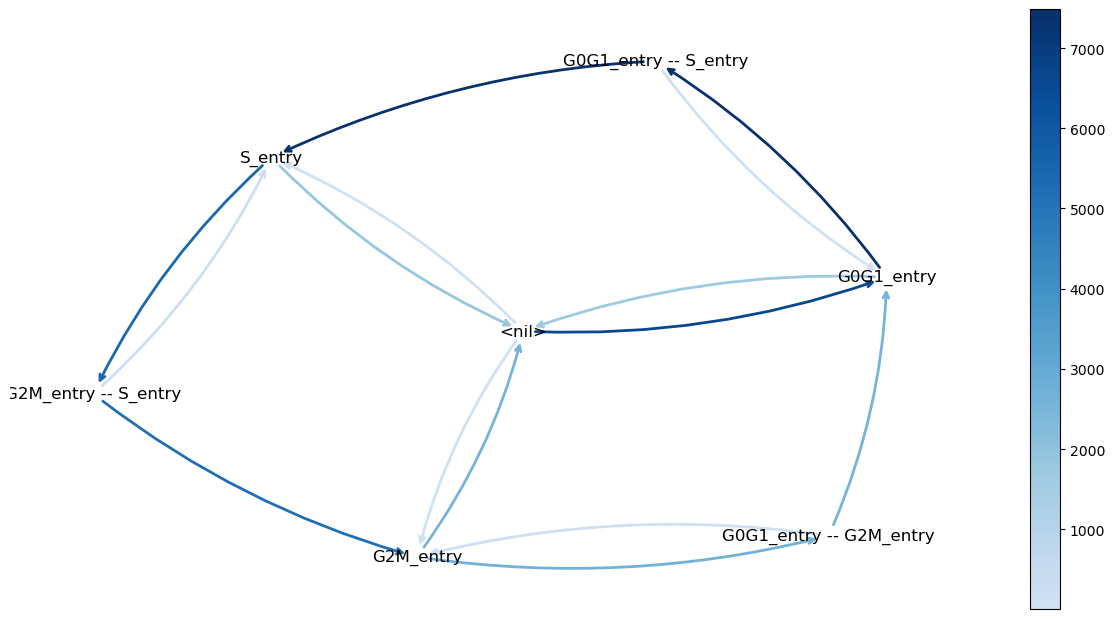

In [79]:
draw_graph_from_pandas(data)

We can observe that, starting from a \<nil\> state, most of the transitions activate G0G1_entry, then activate S_entry, inactivate G1G0_entry, activate G2M_entry, inactivate S_entry. Then we have half of the transitions inactivating G2M_entry and the other half activating G0G1_entry. 

We can compute the same matrix but instead of transition counts, we have the probabilities. 

In [87]:
probas = pd.DataFrame(
    data=np.divide(stg_counts,stg_counts.sum(axis=1)[:, np.newaxis]), 
    index=state_ids.keys(), columns=state_ids.keys()
)
probas

,<nil>,G0G1_entry,G0G1_entry -- G2M_entry,G0G1_entry -- S_entry,G2M_entry,G2M_entry -- S_entry,S_entry
<nil>,0.000000,0.999729,0.000000,0.000000,0.000000,0.000000,0.000271
G0G1_entry,0.189992,0.000000,0.000000,0.810008,0.000000,0.000000,0.000000
G0G1_entry -- G2M_entry,0.000000,0.966674,0.000000,0.000000,0.033326,0.000000,0.000000
G0G1_entry -- S_entry,0.000000,0.011313,0.000000,0.000000,0.000000,0.000000,0.988687
G2M_entry,0.490215,0.000000,0.509785,0.000000,0.000000,0.000000,0.000000
G2M_entry -- S_entry,0.000000,0.000000,0.000000,0.000000,0.965825,0.000000,0.034175
S_entry,0.251785,0.000000,0.000000,0.000000,0.000000,0.748215,0.000000


The subsequent analysis we can do is look at the different observed lists of activation, starting from the \<nil\> state. 

In [88]:
%time paths_dict = compute_circuits(probas, ids_state, '<nil>', 0)

CPU times: user 3.56 ms, sys: 0 ns, total: 3.56 ms
Wall time: 3.58 ms


In [89]:
for proba in sorted(paths_dict, reverse=True):
    #if proba > 0.01:
    print("%.2f : %s" % (proba, paths_dict[proba]))

0.28 : ['<nil>', 'G0G1_entry', 'G0G1_entry -- S_entry', 'S_entry', 'G2M_entry -- S_entry', 'G2M_entry']
0.20 : ['<nil>', 'G0G1_entry', 'G0G1_entry -- S_entry', 'S_entry']
0.19 : ['<nil>', 'G0G1_entry']
0.00 : ['<nil>', 'S_entry', 'G2M_entry -- S_entry', 'G2M_entry']
0.00 : ['<nil>', 'S_entry']
0.00 : ['<nil>', 'S_entry', 'G2M_entry -- S_entry', 'G2M_entry', 'G0G1_entry -- G2M_entry', 'G0G1_entry']


We can see that the model is not perfect here : while most of the sequence are complete, a large proportion skips the G2M phase. We refer to these cycles as incomplete cell cycles. 

## Analysis of mutants

We can then look at known mutant affecting the cell cycle, and simulate them to see how the model predicts them. We will also include Caspase 3 as an output node, to see how these mutants affects cell death, and we will simulate them for 480 hours to see long term effects.

First, we look at the wild type, to remind us of its behavior and allow us to compare with mutants below.

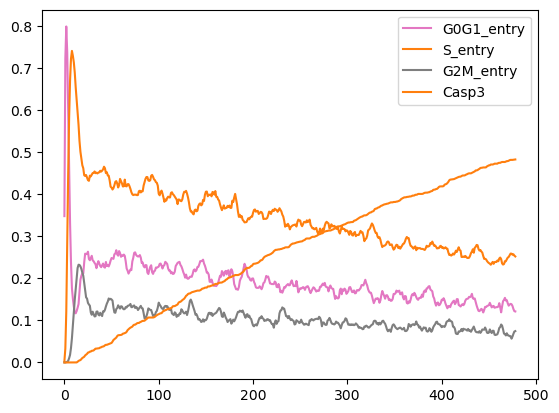

In [111]:
sim_mutants = sim_phenotypes.copy()
sim_mutants.network.set_output(["G0G1_entry", "G2M_entry", "S_entry", "Casp3"])
sim_mutants.update_parameters(max_time=480)
res_mutants = sim_mutants.run()
res_mutants.plot_node_trajectory()

We first look at the Plk1-- mutant, by forcing the inactivation of Plk1 along the simulation. 

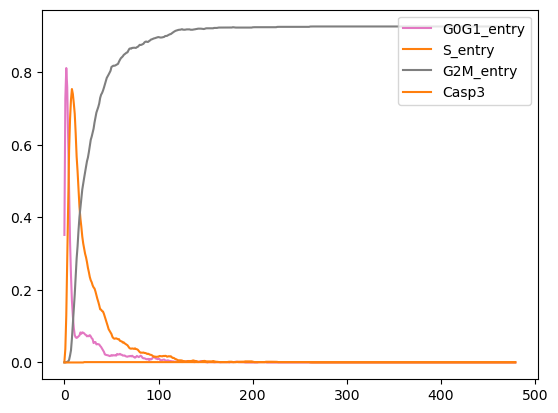

In [109]:
mut_Plk1_OFF = sim_mutants.copy()
mut_Plk1_OFF.mutate("Plk1", "OFF")
mutres_Plk1_OFF = mut_Plk1_OFF.run()
mutres_Plk1_OFF.plot_node_trajectory()

We can see that we don't see any cells in G0G1 nor S phase : cells get stuck in G2M phase.

We then look at the p110++, PI3K++ mutant. 

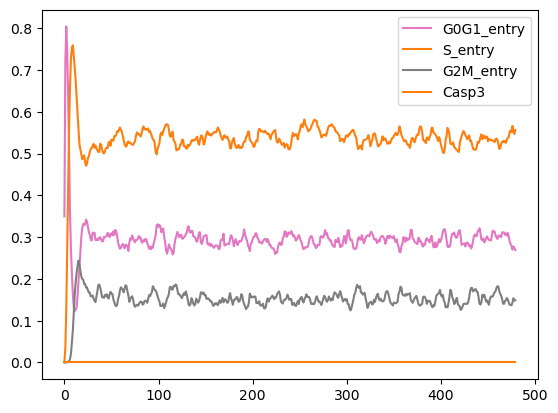

In [110]:
mut_PI3K_p110_ON = sim_mutants.copy()
mut_PI3K_p110_ON.mutate("p110_H", "ON")
mut_PI3K_p110_ON.mutate("PI3K_H", "ON")

mutres_PI3K_p110_ON = mut_PI3K_p110_ON.run()
mutres_PI3K_p110_ON.plot_node_trajectory()

No death ??!!

Finally, we look at the Fox03 mutant.

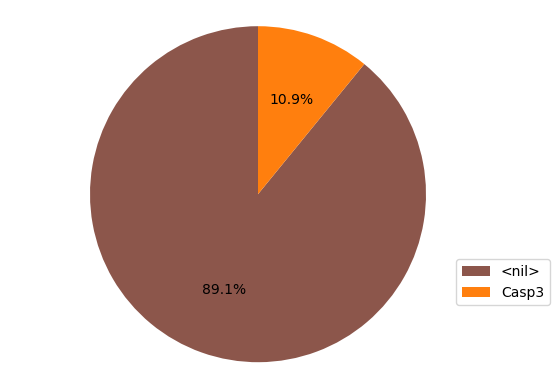

In [112]:
mut_FoxO3_OFF = sim_mutants.copy()
mut_FoxO3_OFF.mutate("FoxO3", "OFF")
mutres_FoxO3_OFF = mut_FoxO3_OFF.run()
mutres_FoxO3_OFF.plot_piechart()

We can see that the cell cycle stops after one or a few cycles.